In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import socket
import os
import glob
import json
import shutil 
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from datetime import timedelta
from importlib import reload
import shutil
from tqdm.notebook import tqdm

from scipy.io import loadmat

# pipeline imports
from pipefinch.pipeline import sglxutil as sglu
from pipefinch.pipeline import rigutil as ru
from pipefinch.pipeline import filestructure as et
from pipefinch.util import spectral as sp


import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2020-08-14 17:10:37,627 - root - INFO - Logger set
2020-08-14 17:10:37,629 - root - INFO - Hostname txori


In [3]:
bird = 'g4r4'
sess_par = {'bird': bird,
           'sess': '20190718_02',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 0, 
           'epoch': None, # for the subfolder in the neuropix data}
           }

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])
exp_struct

mic_chan = 0 # this should come from the rig metadata
s_f = 20000 # only for specgrams, should come from nidq.meta file
# get the pats
dat_mic_path = exp_struct['files']['dat_mic']
dat_mic_path

'/mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/processed/20190718_02/dat_mic.mat'

#### get all the microphone events

In [79]:
def get_mic_events(dat_mic_path: str) -> pd.DataFrame:
    dat_mic = loadmat(exp_struct['files']['dat_mic'])['dx_mic'][0]
    dat_columns = ['rw_sess_epoch', 'rw_file', 'onset', 'len', 'label', 'sublabel', 'cluster', 'context']
    ev_pd = pd.concat([pd.DataFrame(d, columns=dat_columns) for d in dat_mic])
    for k in ev_pd.columns:
        ev_pd[k] = ev_pd[k].apply(lambda x: x.flatten()[0])
    ev_pd[['sess', 'epoch']] = ev_pd['rw_sess_epoch'].str.split('\\', expand=True)
    ev_pd.drop(labels=['rw_sess_epoch'], axis=1, inplace=True)
    ev_pd.reset_index(inplace=True, drop=True)
    ev_pd['offset'] = ev_pd['onset'] + ev_pd['len']
    return ev_pd

def get_audio_evt(dat_mic_path: str) -> pd.DataFrame:
    # get the audio events from the new files created by Corinna
    # it has the same info but arrange differently and does not refer to the raw data file
    events = ['onset', 'duration', 'isdir', 'group', 'fsource']
    ev_folder = os.path.split(dat_mic_path)[0]
    events_dict= {ev_name: 
                  np.load(os.path.join(ev_folder, 
                                       'audioevt_{}.npy'.format(ev_name))).flatten() for ev_name in events}
    return pd.DataFrame(events_dict)

ev_pd = get_mic_events(dat_mic_path)
audio_ev_pd = get_audio_evt(dat_mic_path)

## merge them so we can keep the fsource, to be able to link with the spikes
ev_pd = ev_pd.merge(audio_ev_pd, on=['onset']).drop(['duration', 'group'], axis=1)

sess_epochs = np.unique(ev_pd['epoch'])
sess_clusters = np.unique(ev_pd['cluster'])
sess_labels = np.unique(ev_pd['label'])

ev_pd.head()

,rw_file,onset,len,label,sublabel,cluster,context,sess,epoch,offset,isdir,fsource
0,raw_undir_01_g0_t0.nidq.bin,173451,810,noise,0,20,undir,20190718_02,raw_undir_01_g0,174261,0,1
1,raw_undir_01_g0_t0.nidq.bin,342276,1454,noise,0,20,undir,20190718_02,raw_undir_01_g0,343730,0,1
2,raw_undir_01_g0_t0.nidq.bin,430637,958,noise,0,20,undir,20190718_02,raw_undir_01_g0,431595,0,1
3,raw_undir_01_g0_t0.nidq.bin,431605,942,noise,0,20,undir,20190718_02,raw_undir_01_g0,432547,0,1
4,raw_undir_01_g0_t0.nidq.bin,432882,1435,noise,0,20,undir,20190718_02,raw_undir_01_g0,434317,0,1


In [74]:
audio_ev_pd.head()

,onset,duration,isdir,group,fsource
0,173451,810,0,20,1
1,342276,1454,0,20,1
2,430637,958,0,20,1
3,431605,942,0,20,1
4,432882,1435,0,20,1


### get the spike events

In [71]:
sort_path = exp_struct['folders']['processed']

def get_spikes(sort_path: str) -> pd.DataFrame:
    # load the spike times, spike cluster files and source filesand make a table in pd.Dataframe format
    
    # ditcionary of events and file names
    events_fnames = {'t': 'spk_times.npy', 'clu': 'spk_cluster.npy', 'rw_file_id': 'spk_fsource.npy'}
    events_dict= {k: np.load(os.path.join(sort_path,v)).flatten() for k,v in events_fnames.items()}
    
    return pd.DataFrame(events_dict)

def get_clu_info(sort_path: str) -> pd.DataFrame:
    clu_info_path = os.path.join(sort_path, 'spk_cluster_info.tsv')
    return pd.read_csv(clu_info_path, sep='\t', header=0)


spk_pd = get_spikes(sort_path)

clu_pd = get_clu_info(sort_path)

In [63]:
spk_pd.head()

,t,clu,rw_file
0,300,3,1
1,585,3,1
2,717,3,1
3,857,3,1
4,1085,3,1


In [72]:
clu_pd.head()

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,0,49.6,302.8,mua,2.047543,3,40.0,3.740391,noise,50201,0
1,1,30.7,208.6,mua,2.074765,3,40.0,7.607371,noise,102101,0
2,2,31.9,200.1,mua,2.140746,3,40.0,10.493450,noise,140836,0
3,3,73.5,0.6,good,5.383957,11,120.0,92.563065,good,1242319,0
4,4,82.4,163.2,mua,2.670295,22,240.0,0.183290,noise,2460,0


In [44]:
def cluster_count(pd):
    clu_list = np.unique(pd['cluster'])
    clu_count_dict = {clu: (ev_pd['cluster']==clu).sum() for clu in clu_list}
    return clu_count_dict

clu_count_dict = cluster_count(ev_pd)
clu_count_dict

{2: 581, 3: 341, 6: 1, 7: 3181, 8: 180, 10: 267, 20: 5382}

In [45]:
np.array(list(sess_epochs)).flatten()

array(['raw_dark_01_g0', 'raw_dark_01_g1', 'raw_dark_01_g2',
       'raw_dark_01_g3', 'raw_dir_01_g0', 'raw_dir_02_g0',
       'raw_undir_01_g0', 'raw_undir_02_g0', 'raw_undir_02_g1',
       'raw_undir_03_g0', 'raw_undir_03_g1'], dtype='<U15')

### Identify motifs (incomplete)

In [58]:
## get silences between vocal elements larger than 100ms starting with a given syllable
## get an onset/offset for anything between those silences
song_clu = [2, 3]
pd_slice = (ev_pd['cluster'].isin(clu))

ev_pd.loc[pd_slice, 'gap'] = ev_pd.loc[pd_slice, 'onset'] - ev_pd.shift(-1).loc[ev_pd.shift(-1)['cluster'].isin(clu), 'offset']


In [59]:
ev_pd.loc[pd_slice].head()

,rw_file,onset,len,label,sublabel,cluster,context,sess,epoch,rw_stream,spec,offset,gap
42,raw_undir_01_g0_t0.nidq.bin,2347741,7775,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[402, 393, 386, 386, 394, 373, 366, 362, 332, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",2355516,-16377.0
43,raw_undir_01_g0_t0.nidq.bin,2356481,7637,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[95, 76, 66, 70, 71, 50, 49, 51, 32, 31, 35, 4...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",2364118,-17016.0
44,raw_undir_01_g0_t0.nidq.bin,2365884,7613,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[157, 159, 168, 168, 178, 179, 175, 181, 180, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",2373497,-11820.0
45,raw_undir_01_g0_t0.nidq.bin,2375255,2449,syl_B,0,3,undir,20190718_02,raw_undir_01_g0,"[-145, -152, -156, -139, -140, -134, -132, -13...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",2377704,-10427.0
46,raw_undir_01_g0_t0.nidq.bin,2378125,7557,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[364, 362, 358, 358, 353, 359, 358, 362, 353, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",2385682,-118217.0


### fill the microphone streams for all the events of a given epoch

In [46]:
clu_type = Union[int, list, np.array, None]
epoch_type = Union[str, list, np.array, None]

def get_mic_streams(ev_pd: pd.DataFrame, epochs: epoch_type, clu: clu_type, pre=-512, post=0):
    # open the file for the cluster
    # get the bits from onset + pre, offset + post
    if clu is None:
        clu = np.unique(ev_pd['cluster'])
    else:
        clu = np.array([clu]).flatten()
    
    if epochs is None:
        epochs = np.unique(ev_pd['epoch'])
    else:
        epochs = np.array([epochs]).flatten()
    
        
    logger.info('reading mic streams for all epoch {}  / clu {}'.format(epochs, clu))
    
    for epoch in tqdm(epochs, total=epochs.size):
        epoch_file_list = np.unique(ev_pd.loc[ev_pd['epoch']==epoch]['rw_file'])
        for rw_file in epoch_file_list:
            raw_path = os.path.join(exp_struct['folders']['raw'], epoch, rw_file)
            ni_data = sglu.get_ni_data(raw_path)
            mic_stream = ni_data['adc'][mic_chan]

            pd_slice = (ev_pd['rw_file']==rw_file) & (ev_pd['cluster'].isin(clu))
            get_slice = lambda df: mic_stream[df['onset'] + pre : df['onset'] + df['len'] + post]
            ev_pd.loc[pd_slice, 'rw_stream'] = ev_pd.loc[pd_slice].apply(get_slice , axis=1)
    return ev_pd

ev_pd = get_mic_streams(ev_pd, sess_epochs[:], clu=[2,3, 7])

2020-08-14 17:34:18,497 - root - INFO - reading mic streams for all epoch ['raw_dark_01_g0' 'raw_dark_01_g1' 'raw_dark_01_g2' 'raw_dark_01_g3'
 'raw_dir_01_g0' 'raw_dir_02_g0' 'raw_undir_01_g0' 'raw_undir_02_g0'
 'raw_undir_02_g1' 'raw_undir_03_g0' 'raw_undir_03_g1']  / clu [2 3 7]


2020-08-14 17:34:18,546 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/raw/20190718_02/raw_dark_01_g0/raw_dark_01_g0_t0.nidq.meta
2020-08-14 17:34:19,157 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/raw/20190718_02/raw_dark_01_g1/raw_dark_01_g1_t0.nidq.meta
2020-08-14 17:34:23,980 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/raw/20190718_02/raw_dark_01_g2/raw_dark_01_g2_t0.nidq.meta
2020-08-14 17:34:59,832 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/raw/20190718_02/raw_dark_01_g3/raw_dark_01_g3_t0.nidq.meta
2020-08-14 17:37:16,044 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/raw/20190718_02/raw_dir_01_g0/raw_dir_01_g0_t0.nidq.meta
2020-08-14 17:37:50,193 - pipefinch.pipeline.sglxutil - INFO - meta file /mnt/cube/earneodo/basal

In [55]:
### get all spectrograms
clu = [2, 3]
pd_slice = (ev_pd['cluster'].isin(clu))
ev_pd.loc[pd_slice, 'spec'] = ev_pd.loc[pd_slice, 'rw_stream'].apply(lambda x: sp.ms_spectrogram(x, s_f)[2])
ev_pd.loc[pd_slice].head()

,rw_file,onset,len,label,sublabel,cluster,context,sess,epoch,rw_stream,spec
42,raw_undir_01_g0_t0.nidq.bin,2347741,7775,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[402, 393, 386, 386, 394, 373, 366, 362, 332, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
43,raw_undir_01_g0_t0.nidq.bin,2356481,7637,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[95, 76, 66, 70, 71, 50, 49, 51, 32, 31, 35, 4...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
44,raw_undir_01_g0_t0.nidq.bin,2365884,7613,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[157, 159, 168, 168, 178, 179, 175, 181, 180, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
45,raw_undir_01_g0_t0.nidq.bin,2375255,2449,syl_B,0,3,undir,20190718_02,raw_undir_01_g0,"[-145, -152, -156, -139, -140, -134, -132, -13...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
46,raw_undir_01_g0_t0.nidq.bin,2378125,7557,syl_A,0,2,undir,20190718_02,raw_undir_01_g0,"[364, 362, 358, 358, 353, 359, 358, 362, 353, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


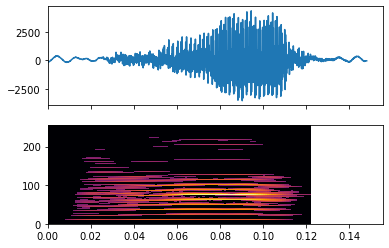

In [54]:
one_ev = ev_pd.iloc[45]

x = one_ev['rw_stream']
s_f = 20000
sx = one_ev['spec']
fg, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(np.arange(x.size)/s_f, x)
ax[1].pcolormesh(np.arange(sx.shape[1])*0.001, np.arange(sx.shape[0]), np.log(sx), cmap='inferno')

### get the rolling umaps

In [17]:
from swissknife.streamtools import dimension as dim
from swissknife.streamtools.core import data as dt
import umap

/mnt/cube/earneodo/envs/pipefinch/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


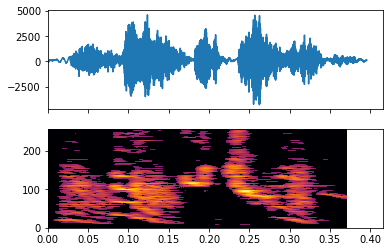

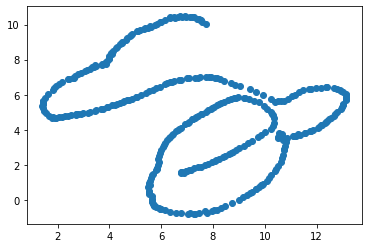

In [19]:
# get rolling umap for just the one syllable
one_ev = ev_pd.iloc[51]

x = one_ev['rw_stream']
s_f = 20000
sx = one_ev['spec']
fg, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(np.arange(x.size)/s_f, x)
ax[1].pcolormesh(np.arange(sx.shape[1])*0.001, np.arange(sx.shape[0]), np.log(sx), cmap='inferno')

red, emb, rxflat = dim.rolling_umap(sx, 10, random_state=42)
plt.figure()
plt.scatter(*emb.T);

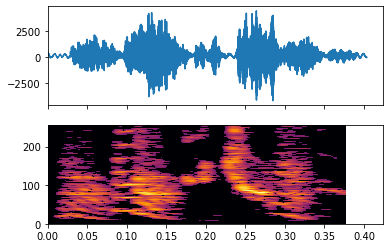

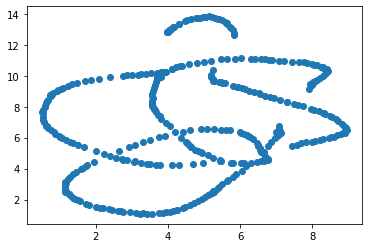

In [20]:
one_ev = ev_pd.iloc[46]

x = one_ev['rw_stream']
s_f = 20000
sx = one_ev['spec']
fg, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(np.arange(x.size)/s_f, x)
ax[1].pcolormesh(np.arange(sx.shape[1])*0.001, np.arange(sx.shape[0]), np.log(sx), cmap='inferno')

red, emb, rxflat = dim.rolling_umap(sx, 10, reducer=None)
plt.figure()
plt.scatter(*emb.T);

In [96]:
### get an embedding for all syllables of one clu
# get all the spectrograms rolled, stack them
# get the embedding for all of them
# project all of them separately

roll_spec = lambda sx: dt.feature_flat(dt.rolling_window(sx, 50))

ev_pd.loc[pd_slice, 'rolled_sx'] = ev_pd.loc[pd_slice, 'spec'].apply(roll_spec)

In [98]:
all_rolled_flat_feat = np.hstack(ev_pd.loc[pd_slice, 'rolled_sx'])
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(all_rolled_flat_feat.T)

In [99]:
plt.scatter?

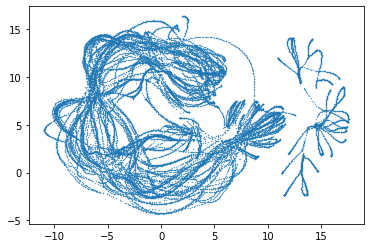

In [100]:
plt.scatter(*embedding.T, s=0.1);

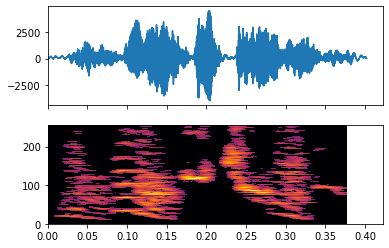

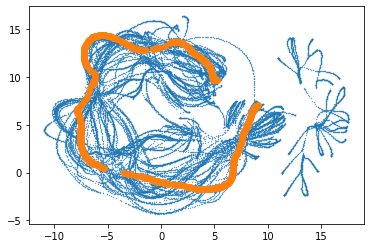

In [103]:
one_ev = ev_pd.iloc[48]

x = one_ev['rw_stream']
s_f = 20000
sx = one_ev['spec']
fg, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(np.arange(x.size)/s_f, x)
ax[1].pcolormesh(np.arange(sx.shape[1])*0.001, np.arange(sx.shape[0]), np.log(sx), cmap='inferno')

red, emb, rxflat = dim.rolling_umap(sx, 50, reducer=reducer)
plt.figure()
plt.scatter(*embedding.T, s=0.1);
plt.scatter(*emb.T);

In [21]:
def get_roll_umap(ev_pd, pd_slice, win=50):
    # make a single umap embedding for all the syllables
    # project each onto that embedding
    #get the rolled spectrograms
    roll_spec = lambda sx: dt.feature_flat(dt.rolling_window(sx, win))
    ev_pd.loc[pd_slice, 'rolled_sx'] = ev_pd.loc[pd_slice, 'spec'].apply(roll_spec)
    
    # make the embedding
    all_rolled_flat_feat = np.hstack(ev_pd.loc[pd_slice, 'rolled_sx'])
    reducer = umap.UMAP(random_state=42)
    logger.info('getting umap embedding for (n_samples, n_feat) = {}'.format(all_rolled_flat_feat.T.shape))
    embedding = reducer.fit_transform(all_rolled_flat_feat.T)
    
    # project each
    logger.info('projecting all {} spectrograms'.format(pd_slice.sum()))
    project = lambda sx: dim.rolling_umap(sx, win, reducer=reducer)[1]
    tqdm.pandas(desc='projecting all spectrograms')
    ev_pd.loc[pd_slice, 'umap_{}'.format(win)] = ev_pd.loc[pd_slice, 'spec'].progress_apply(project)
    
    return reducer, embedding

clu = [2, 3]
pd_slice = (ev_pd['cluster'].isin(clu))
reducer, embedding = get_roll_umap(ev_pd, pd_slice, win=50)

2020-07-02 21:59:10,061 - root - INFO - getting umap embedding for (n_samples, n_feat) = (216078, 12850)
2020-07-02 22:36:52,968 - root - INFO - projecting all 922 spectrograms
/mnt/cube/earneodo/envs/pipefinch/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [22]:
np.where(pd_slice)[0].shape

(922,)

In [23]:
ev_pd.head()

,rw_file,onset,len,label,sublabel,cluster,context,sess,epoch,rw_stream,spec,rolled_sx,umap_50
0,raw_undir_01_g0_t0.nidq.bin,173451,810,noise,0,20,undir,20190718_02,raw_undir_01_g0,NaN,NaN,NaN,NaN
1,raw_undir_01_g0_t0.nidq.bin,342276,1454,noise,0,20,undir,20190718_02,raw_undir_01_g0,NaN,NaN,NaN,NaN
2,raw_undir_01_g0_t0.nidq.bin,430637,958,noise,0,20,undir,20190718_02,raw_undir_01_g0,NaN,NaN,NaN,NaN
3,raw_undir_01_g0_t0.nidq.bin,431605,942,noise,0,20,undir,20190718_02,raw_undir_01_g0,NaN,NaN,NaN,NaN
4,raw_undir_01_g0_t0.nidq.bin,432882,1435,noise,0,20,undir,20190718_02,raw_undir_01_g0,NaN,NaN,NaN,NaN


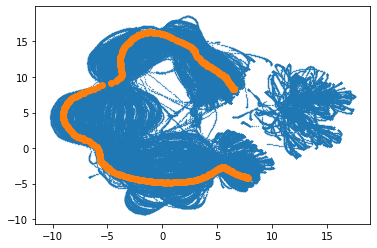

In [25]:
plt.scatter(*embedding.T, s=0.1);

one_ev = ev_pd.iloc[47]
plt.scatter(*one_ev['umap_50'].T);

3676    [[9.899443, -1.4755175], [9.893896, -1.4250592...
3677    [[10.044035, -2.1192002], [10.07215, -2.147662...
3678    [[10.920595, 3.6405566], [10.918776, 3.5890825...
3679    [[10.060233, -1.9942796], [10.056802, -1.97603...
3680    [[11.020024, 3.6186635], [11.038099, 3.5836935...
                              ...                        
9565    [[9.034998, -0.25989226], [9.003672, -0.261031...
9566    [[10.224735, 5.0027637], [10.225192, 4.947436]...
9567    [[9.01264, -0.26641077], [9.0057745, -0.266277...
9568    [[10.12903, 5.262119], [10.105913, 5.184699], ...
9569    [[8.971589, -0.22998883], [8.952243, -0.225788...
Name: umap_50, Length: 68, dtype: object

In [53]:
undir_sample

array([15, 45,  7, 44, 37, 51, 57, 47, 29, 17, 25, 41, 53,  3, 63,  0, 67,
       55, 36, 19, 59, 60,  6,  2, 48, 14, 24, 65, 42, 27, 46, 49,  9, 34,
       30, 12, 56, 38, 58, 11, 52, 61, 62, 50, 10, 35, 20, 28, 64, 54, 33,
        4, 21, 39, 32, 40, 18, 66,  8, 43, 13,  1, 22, 23, 26, 31,  5, 16])

In [100]:
# attempt a 'balance' in the samples, since there will be more  of one than the other
clu=[2]
undir_slice = (ev_pd['cluster'].isin(clu)) & (ev_pd['context']=='undir')
n_undir = undir_slice.sum()

dir_slice = (ev_pd['cluster'].isin(clu)) & (ev_pd['context']=='dir')
n_dir = dir_slice.sum()

n_balance = np.min([n_undir, n_dir])
undir_sample, dir_sample = [np.random.permutation(np.arange(n)[:n_balance]) for n in [n_undir, n_dir]]

fig, ax = plt.subplots()

undir_emb = np.vstack(ev_pd.loc[undir_slice].reset_index().loc[undir_sample, 'umap_50'])
ax.scatter(*undir_emb.T, s=0.2, label='undirected');
dir_emb = np.vstack(ev_pd.loc[dir_slice].reset_index().loc[dir_sample, 'umap_50'])
ax.scatter(*dir_emb.T, s=0.2, label='directed');
ax.legend()


fig_path = os.path.join(exp_struct['folders']['processed'], 'umap_{}_dir_undir.png'.format(50))
logger.info('saving figure to {}'.format(fig_path))
fig.savefig(fig_path, format='png')

fig.show()

2020-07-03 12:43:11,182 - root - INFO - saving figure to /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/processed/20190718_02/umap_50_dir_undir.png


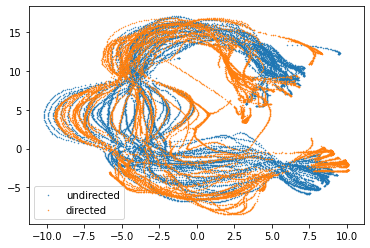

In [101]:
fig.show()

(15573, 2)

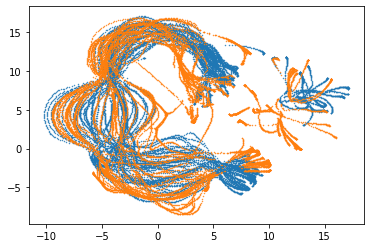

In [82]:
dir_emb.shape

2020-07-03 10:59:25,466 - root - INFO - saving figure to /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/processed/20190718_02/umap_{}_dir_undir.png


'/mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/processed/20190718_02'

In [71]:
(ev_pd.loc[undir_slice].reset_index().loc[undir_slice, 'umap_50'])

42     [[8.224754, -5.1468825], [8.181658, -5.188536]...
43     [[12.7335005, 6.3853955], [12.814948, 6.313168...
44     [[7.502945, -5.8088956], [7.489091, -5.8209605...
45     [[12.257056, 6.9319677], [12.388035, 7.055546]...
46     [[8.328122, -4.495839], [8.292463, -4.44831], ...
47     [[8.779547, -3.5160718], [8.754986, -3.596572]...
48     [[8.653735, -4.4555964], [8.682934, -4.4538407...
49     [[8.954781, -2.7601779], [8.946531, -2.7580392...
50     [[12.657242, 6.559871], [12.69547, 6.558318], ...
51     [[8.605573, -1.8064985], [8.591891, -1.7824284...
320    [[10.562591, 6.7135487], [10.576949, 6.782041]...
321    [[7.783746, -4.1594524], [7.804155, -4.178536]...
322    [[8.904488, -2.9797983], [8.903292, -2.9856632...
323    [[8.761164, -4.3720407], [8.792932, -4.343124]...
324    [[8.741261, -4.416689], [8.75172, -4.3655863],...
362    [[8.7048855, -3.809628], [8.710873, -3.7873826...
363    [[12.567039, 6.4851556], [12.662733, 6.5183916...
364    [[9.266324, -3.3614078],

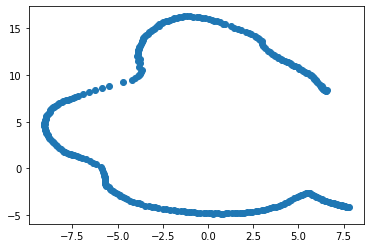

In [121]:
emb = one_ev['umap_50']
plt.scatter(*emb.T);

In [119]:
from scipy import interpolate as interp

def resize_interp1d(x, new_n, kind='linear'):
    f = interp.interp1d(np.linspace(0, 1, x.size), x, kind)
    return f(np.linspace(0, 1, new_n))

def resize_interp(y:np.array, new_n:int, kind:str='linear'):
    #interpolate along the last axis
    z = np.vstack([resize_interp1d(x, new_n, kind=kind) for x in y.T]).T
    
    return z

In [105]:
clu = 2
int(np.median(ev_pd.loc[ev_pd['cluster'] == clu, 'umap_50'].apply(lambda x: x.shape[0])))

329.0

In [126]:
### resample all umap projections for each cluster to the median
one_clu = 3
clu_slice = (ev_pd['cluster'] == one_clu)
umap_key = 'umap_50'

median_len = int(np.median(ev_pd.loc[clu_slice, umap_key].apply(lambda x: x.shape[0])))

ev_pd.loc[clu_slice, 'umap_resample'] = ev_pd.loc[clu_slice, 'umap_50'].apply(lambda x: resize_interp(x, median_len))

In [196]:
# attempt a 'balance' in the samples, since there will be more  of one than the other
clu=[2]
undir_slice = (ev_pd['cluster'].isin(clu)) & (ev_pd['context']=='undir')
n_undir = undir_slice.sum()

dir_slice = (ev_pd['cluster'].isin(clu)) & (ev_pd['context']=='dir')
n_dir = dir_slice.sum()

n_balance = np.min([n_undir, n_dir])
undir_sample, dir_sample = [np.random.permutation(np.arange(n)[:n_balance]) for n in [n_undir, n_dir]]

fig, ax = plt.subplots()

undir_emb = np.stack(ev_pd.loc[undir_slice].reset_index().loc[undir_sample, 'umap_resample'], axis=1)
ax.scatter(*undir_emb.T, s=0.2, label='undirected');
dir_emb = np.stack(ev_pd.loc[dir_slice].reset_index().loc[dir_sample, 'umap_resample'], axis=1)
ax.scatter(*dir_emb.T, s=0.2, label='directed');
ax.legend()


fig_path = os.path.join(exp_struct['folders']['processed'], 'umap_{}_dir_undir.png'.format(50))
logger.info('saving figure to {}'.format(fig_path))
fig.savefig(fig_path, format='png')

fig.show()

2020-07-03 22:21:51,285 - root - INFO - saving figure to /mnt/cube/earneodo/basalganglia/birds/g4r4/Ephys/processed/20190718_02/umap_50_dir_undir.png


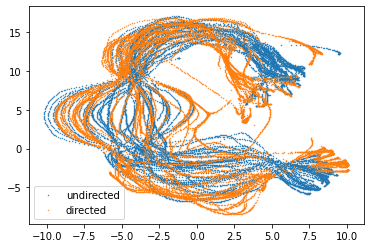

In [197]:
fig.show()

In [198]:
undir_emb.shape

(329, 41, 2)

In [201]:
s_undir = ev_pd.loc[undir_slice].reset_index().loc[undir_sample[7], 'spec']
s_dir = ev_pd.loc[dir_slice].reset_index().loc[dir_sample[7], 'spec']

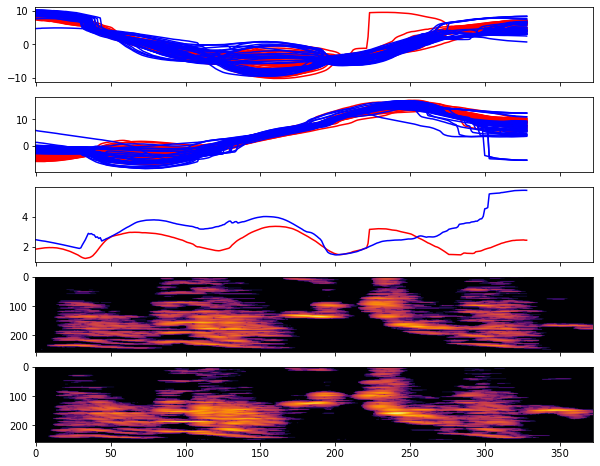

In [202]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 8), sharex=True)
ax[0].plot(undir_emb[:, :,0], 'r');
ax[0].plot(dir_emb[:, :,0], 'b');

ax[1].plot(undir_emb[:, :, 1], 'r');
ax[1].plot(dir_emb[:, :, 1], 'b');

ax[2].plot(undir_emb.std(axis=1).sum(axis=1), 'r')
ax[2].plot(dir_emb.std(axis=1).sum(axis=1), 'b')

ax[3].imshow(np.log(s_undir[::-1]), cmap='inferno', aspect='auto')
ax[4].imshow(np.log(s_dir[::-1]), cmap='inferno', aspect='auto')

In [161]:
undir_emb.std(axis=1).shape

(329, 2)